In [ ]:
import numpy                as np
import pandas               as pd
import matplotlib.pyplot    as plt
import matplotlib.cm        as cm
import networkx             as nx
from matplotlib.colors      import LinearSegmentedColormap
from datetime               import datetime
from google.cloud           import bigquery
from google.oauth2          import service_account
from google.cloud.bigquery  import Client

In [2]:
credentials = service_account.Credentials.from_service_account_file('nowheredata-9b61624b5615.json')
client = bigquery.Client(credentials=credentials, project='nowheredata')

In [3]:
def get_data(sql_file, var):  
    if var == True:
        dados = client.query(sql_file)
        result = dados.result()
        df = result.to_dataframe()
        return df
    else:
        with open(sql_file, 'r') as f:
            sql = f.read()
        dados = client.query(sql)
        result = dados.result()
        df = result.to_dataframe()
        return df

In [6]:
query = fr"""
SELECT *
  FROM `nowheredata.evaluated_tables.item_basket_analysis`
"""

df = get_data(query, True)
df['item_id_a_cat'] = pd.Categorical(df['item_id_a']).codes
df['item_id_b_cat'] = pd.Categorical(df['item_id_b']).codes
df

,item_id_a,item_id_b,order_count,total_orders_item_a,total_orders_item_b,total_orders_company,suport,confidence,denominator_lift,lift,item_id_a_cat,item_id_b_cat
0,80738,10051,1,644,51,16733,0.0001,0.0016,0.0030,0.5333,144,0
1,70185,10051,1,229,51,16733,0.0001,0.0044,0.0030,1.4667,115,0
2,21032,10051,1,392,51,16733,0.0001,0.0026,0.0030,0.8667,24,0
3,42894,10051,1,54,51,16733,0.0001,0.0185,0.0030,6.1667,67,0
4,98158,10051,1,394,51,16733,0.0001,0.0025,0.0030,0.8333,173,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4055,71496,24524,39,191,155,16733,0.0023,0.2042,0.0093,21.9570,120,32
4056,24524,60146,39,155,204,16733,0.0023,0.2516,0.0122,20.6230,32,90
4057,24524,71496,39,155,191,16733,0.0023,0.2516,0.0114,22.0702,32,120
4058,71496,60146,46,191,204,16733,0.0027,0.2408,0.0122,19.7377,120,90


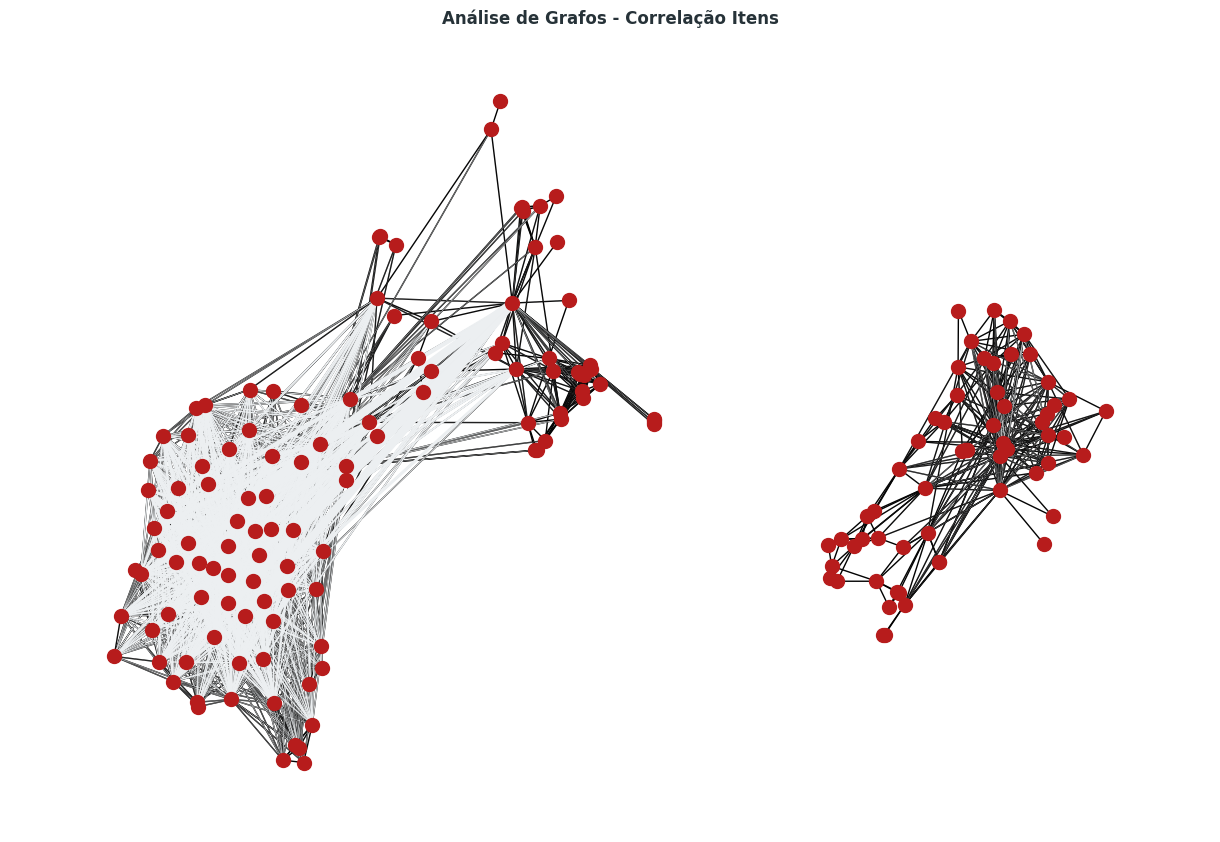

In [8]:
# Criar o grafo
G = nx.Graph()

# Adicionar arestas com pesos baseados no lift
for index, row in df.iterrows():
    G.add_edge(row['item_id_a'], row['item_id_b'], weight=row['lift'], confidence=row['confidence'], inverted_weight=1 / row['lift'])

# Obter os pesos das arestas e inverter os pesos
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]
inverted_weights = [1 / weight if weight != 0 else 0 for weight in weights]

# Desenhar o grafo
pos = nx.spring_layout(G, weight='weight', seed=15)

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=False, node_size=100, node_color='#B71C1C', font_size=10, font_weight='bold')
# nx.draw_networkx_edge_labels(G, pos, edge_labels={(edge[0], edge[1]): f"{edge[2]['weight']:.2f}" for edge in edges})
    
colors = ['#ECEFF1','#263238']
n_bins = 200
cmap_name = 'cinza'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

nx.draw_networkx_edges(G, pos, width=inverted_weights, edge_color=weights, edge_cmap=cm)
plt.title("Análise de Grafos - Correlação Itens", fontweight='bold', fontsize=12, ha='center', color='#263238')

# plt.savefig('grafo_filtro_80.png', format='png', dpi=300)
plt.show()

In [9]:
import community as community_louvain

# Aplicando o algoritmo Louvain
partition = community_louvain.best_partition(G)

# Adicionando as comunidades como atributos dos nós no grafo original
nx.set_node_attributes(G, partition, 'community')

num_communities = len(set(partition.values()))

print(f"Number of communities detected: {num_communities}")
print(f"Communities: {set(partition.values())}")

Number of communities detected: 12
Communities: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}


In [29]:
df_dim = df[['item_id_a','item_id_a_cat']].drop_duplicates().reset_index(drop=True)
df_dim.columns = ['product_id','categoria']

df_dim['community'] = df_dim['product_id'].map(partition)

print(f"Número de itens sem comunidade: {df_dim['community'].isna().sum()}")

if df_dim['community'].isna().sum() > 0:
    print("Itens sem comunidade encontrados:")
    print(df_dim[df_dim['community'].isna()]['product_id'].unique())

macro_partition = {}
for macro_id, comp in enumerate(nx.connected_components(G)):
    for node in comp:
        macro_partition[node] = macro_id

# 2) adiciona coluna sem mexer no df_dim atual
df_dim["macro_community"] = df_dim["product_id"].map(macro_partition)

print("Itens sem macro:", df_dim["macro_community"].isna().sum())
print("Qtd macrocomunidades:", df_dim["macro_community"].nunique(dropna=True))

Número de itens sem comunidade: 0
Itens sem macro: 0
Qtd macrocomunidades: 2


In [30]:
df_dim

,product_id,categoria,community,macro_community
0,80738,144,0,0
1,70185,115,0,0
2,21032,24,0,0
3,42894,67,0,0
4,98158,173,0,0
...,...,...,...,...
171,29614,45,11,1
172,28219,42,7,0
173,62377,97,5,1
174,63635,102,11,1


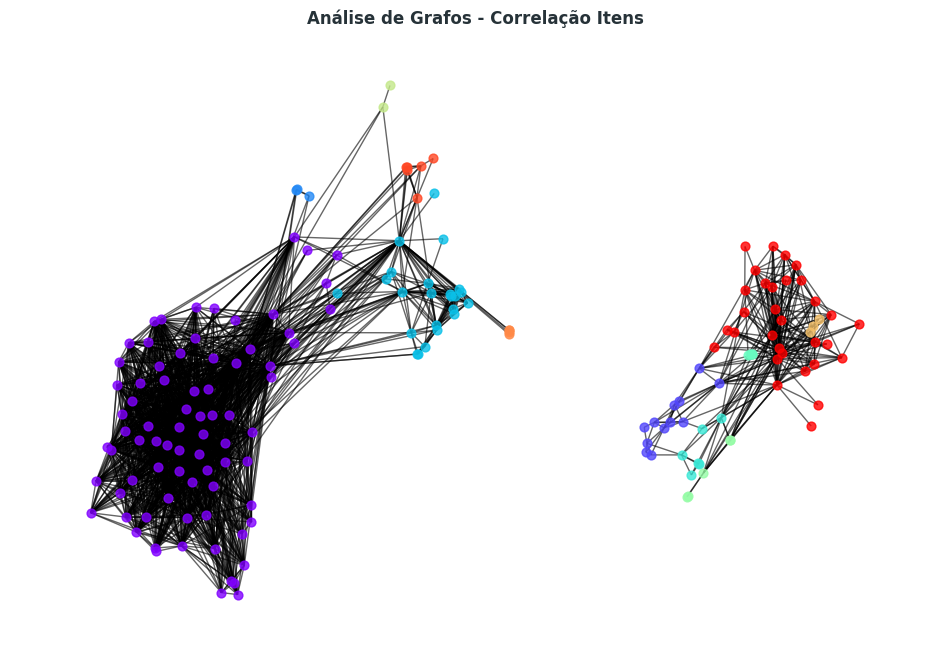

In [16]:
# Adicionar as comunidades como atributos dos nós no grafo original
nx.set_node_attributes(G, partition, 'community')

# Desenhar o grafo com as comunidades coloridas
pos = nx.spring_layout(G, weight='weight', seed=15)

# Obter a lista de comunidades
communities = set(partition.values())
colors = cm.rainbow(np.linspace(0, 1, len(communities)))

plt.figure(figsize=(12, 8))

# Desenhar os nós com cores baseadas na comunidade
for community, color in zip(communities, colors):
    nodes_in_community = [node for node, comm in partition.items() if comm == community]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_in_community, node_size=40, node_color=[color], alpha=0.8)

# Desenhar as arestas com pesos
nx.draw_networkx_edges(G, pos, alpha=0.6)

# Remover os rótulos dos nós
# nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', font_color='white')

plt.title("Análise de Grafos - Correlação Itens", fontweight='bold', fontsize=12, ha='center', color='#263238')

plt.axis('off')  # Remover os eixos
plt.show()

In [31]:
df_dim.dtypes

product_id         Int64
categoria          int16
community          int64
macro_community    int64
dtype: object

In [27]:
project_id = 'nowheredata'
dataset = 'evaluated_tables'
table_name = 'clusterization_items'

In [32]:
schema = [
    bigquery.SchemaField('product_id','INT64', mode='NULLABLE'),
    bigquery.SchemaField('community','INT64', mode='NULLABLE'),
    bigquery.SchemaField('macro_community','INT64', mode='NULLABLE')
]

In [35]:
table_ref = client.dataset(dataset).table(table_name)
try:
    table = client.get_table(table_ref)
    print('A tabela já existe. Os novos dados serão carregados na tabela.')
except:
    print('A tabela não existe. Será criada agora.')
    table = bigquery.Table(table_ref)
    table = client.create_table(table)
    print('A tabela foi criada com sucesso.')

# Carrega os novos dados na tabela existente
job_config = bigquery.LoadJobConfig(write_disposition='WRITE_TRUNCATE', schema=schema)
job = client.load_table_from_dataframe(df_dim[['product_id','community','macro_community']].drop_duplicates(), table_ref, job_config=job_config)
job.result()
print('Os novos dados foram carregados com sucesso na tabela existente.')

A tabela já existe. Os novos dados serão carregados na tabela.
Os novos dados foram carregados com sucesso na tabela existente.


In [36]:
query = fr"""
SELECT * 
  FROM `nowheredata.evaluated_tables.cluster_basket_analysis`
"""

df_cluster = get_data(query, True)

In [39]:
df_cluster

,cluster_name_a,cluster_name_b,order_count,total_orders_cat_a,total_orders_cat_b,total_orders_company,suport,confidence,denominator_lift,lift
0,Stockup Beer,Beverage Replenishment,2,132,8,435,0.0046,0.0152,0.0184,0.8261
1,Social Drinks,Beverage Replenishment,6,134,8,435,0.0138,0.0448,0.0184,2.4348
2,Mixed Basket,Casual Beer,13,22,133,435,0.0299,0.5909,0.3057,1.9329
3,Non Alcoholic,Casual Beer,1,2,133,435,0.0023,0.5000,0.3057,1.6356
4,Home Cocktail,Casual Beer,3,4,133,435,0.0069,0.7500,0.3057,2.4534
5,Casual Beer,Home Cocktail,3,133,4,435,0.0069,0.0226,0.0092,2.4565
6,Casual Beer,Mixed Basket,13,133,22,435,0.0299,0.0977,0.0506,1.9308
7,Casual Beer,Non Alcoholic,1,133,2,435,0.0023,0.0075,0.0046,1.6304
8,Beverage Replenishment,Social Drinks,6,8,134,435,0.0138,0.7500,0.3080,2.4351
9,Stockup Beer,Social Drinks,50,132,134,435,0.1149,0.3788,0.3080,1.2299


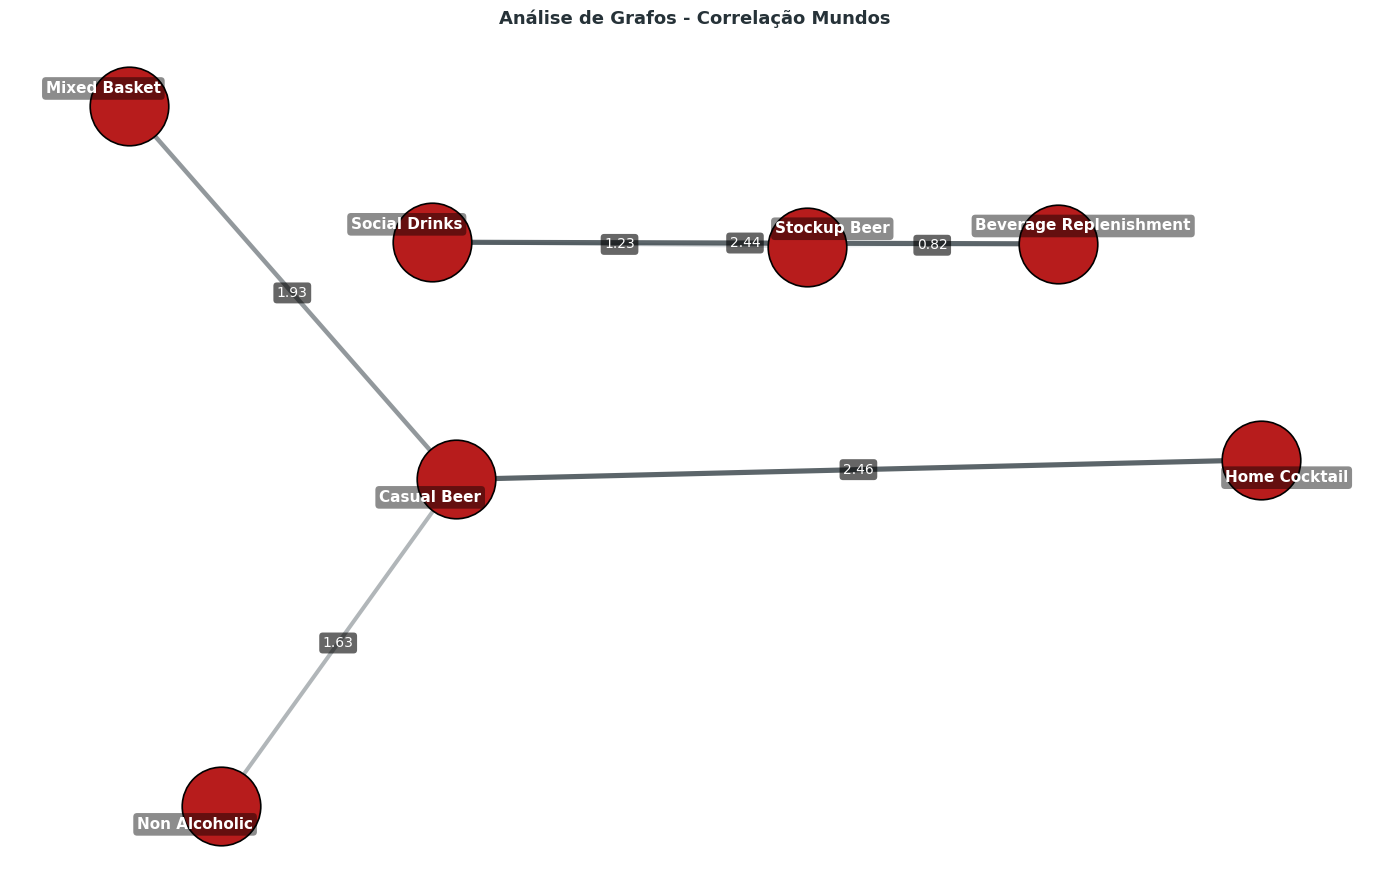

In [45]:
G = nx.Graph()
for _, row in df_cluster.iterrows():
    G.add_edge(row['cluster_name_a'], row['cluster_name_b'], weight=float(row['lift']))

edges = list(G.edges(data=True))
weights = np.array([d['weight'] for _, _, d in edges], dtype=float)

# ----------------------------
# Layout (compact + centralized)
# ----------------------------
pos = nx.kamada_kawai_layout(G, weight='weight')

# center layout around (0,0)
xs = np.array([p[0] for p in pos.values()])
ys = np.array([p[1] for p in pos.values()])
for n in pos:
    pos[n] = (pos[n][0] - xs.mean(), pos[n][1] - ys.mean())

# ----------------------------
# Edge styling (readable scaling)
# ----------------------------
# width: log smooths extremes
edge_widths = np.log1p(weights) * 3.0

# color: normalize clipped range to avoid 1 edge dominating
w_clip = np.clip(weights, np.percentile(weights, 10), np.percentile(weights, 90))
edge_colors = (w_clip - w_clip.min()) / (w_clip.max() - w_clip.min() + 1e-9)

cm = LinearSegmentedColormap.from_list('cinza', ['#ECEFF1', '#263238'], N=200)

# ----------------------------
# Draw
# ----------------------------
plt.figure(figsize=(14, 9))

# edges behind
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    edge_color=edge_colors,
    edge_cmap=cm,
    alpha=0.75
)

# nodes in front
nx.draw_networkx_nodes(
    G, pos,
    node_size=3200,
    node_color='#B71C1C',
    edgecolors='black',
    linewidths=1.2
)

# edge labels (lift)
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in edges}
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_size=10,
    bbox=dict(facecolor='black', edgecolor='none', boxstyle='round,pad=0.25', alpha=0.6),
    font_color='white',
    rotate=False
)

# node labels with small radial offset (reduces overlap)
for node, (x, y) in pos.items():
    dx = 0.04 * (1 if x >= 0 else -1)
    dy = 0.04 * (1 if y >= 0 else -1)
    plt.text(
        x + dx, y + dy, node,
        fontsize=11, ha='center', va='center', fontweight='bold',
        bbox=dict(facecolor='black', edgecolor='none', boxstyle='round,pad=0.25', alpha=0.45),
        color='white'
    )

plt.title("Análise de Grafos - Correlação Mundos", fontweight='bold', fontsize=13, color='#263238')
plt.axis('off')
plt.tight_layout()
plt.show()
